In [11]:

import os
import torch
import torchvision

from tqdm import tqdm
from csng.brainreader_mouse.data import get_brainreader_mouse_dataloaders

DATA_PATH = os.environ["DATA_PATH"]
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, "brainreader")
device = os.environ["DEVICE"]

config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {
        "mixing_strategy": "sequential", # needed only with multiple base dataloaders
        "max_training_batches": None,
    },
    "save_path": os.path.join(DATA_PATH, "models", "imagenet_decoder.pt"),
    "train": True,
}

config["data"]["brainreader_mouse"] = {
    "device": config["device"],
    "mixing_strategy": config["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": 128,
    "sessions": list(range(1, 23)),
    # "sessions": [6],
    "resize_stim_to": (144, 224),
    "normalize_stim": True,
    "normalize_resp": False,
    "div_resp_by_std": True,
    "clamp_neg_resp": False,
    "additional_keys": None,
    "avg_test_resp": True,
}

data_loader = get_brainreader_mouse_dataloaders(config['data']['brainreader_mouse'])["brainreader_mouse"]

dl = data_loader["train"]
print("Batches: ", len(dl))
batch = next(dl)
data = batch[0]
print("Batch length: ", len(batch))
print(data.keys())
for k in ['stim', 'resp',]:
# for k in ['stim', 'resp', 'neuron_coords']:
    print(f"{k}: {data[k].shape}")



Batches:  792
Batch length:  1
dict_keys(['data_key', 'stim', 'resp', 'neuron_coords', 'pupil_center'])
stim: torch.Size([128, 1, 144, 224])
resp: torch.Size([128, 6721])


In [12]:
def stim_to_resnet(stim):
    RESNET_SIZE = 224
    padded_image = torch.zeros(stim.shape[0], 3, RESNET_SIZE, RESNET_SIZE)

    h,w = stim.shape[2:]
    start_h, start_w = (final_size-h)//2, (final_size-w)//2
    stim_color = stim.repeat(1, 3, 1, 1)
    padded_image[:, :, start_h:start_h+h, start_w: start_w + w] = stim_color
    return padded_image

In [13]:

resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')
resnet50.eval().to(device)


batch = next(dl)
assert len(batch) == 1
data = batch[0]

stim = data['stim']
resp = data['resp']
for key in ['stim', 'resp']:
    print(f"{key}: ", data[key].shape)

padded_image = torch.full((stim.shape[0], 3, 224, 224), .5)


final_size = 224
h,w = stim.shape[2:]
start_h, start_w = (final_size-h)//2, (final_size-w)//2
stim_color = stim.repeat(1, 3, 1, 1)
padded_image[:, :, start_h:start_h+h, start_w: start_w + w] = stim_color


with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(padded_image), dim=1)
    results = utils.pick_n_best(predictions=output, n=3)
# Convert first 3 to pil and show in jupyter

Using cache found in /home/miki/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/miki/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


stim:  torch.Size([128, 1, 144, 224])
resp:  torch.Size([128, 6864])
sample 0: [('snail', '90.1%'), ('chambered nautilus, pearly nautilus, nautilus', '0.1%'), ('conch', '0.1%')]
sample 1: [('bucket, pail', '29.7%'), ('bathtub, bathing tub, bath, tub', '19.7%'), ('tub, vat', '9.3%')]
sample 2: [('baseball', '91.0%'), ('ballplayer, baseball player', '0.4%'), ('buckle', '0.3%')]
sample 3: [('ruffed grouse, partridge, Bonasa umbellus', '79.2%'), ('partridge', '3.8%'), ('web site, website, internet site, site', '0.3%')]
sample 4: [('sea lion', '69.8%'), ('killer whale, killer, orca, grampus, sea wolf, Orcinus orca', '1.0%'), ('dugong, Dugong dugon', '0.9%')]
sample 5: [('banjo', '80.5%'), ('seashore, coast, seacoast, sea-coast', '0.2%'), ('drum, membranophone, tympan', '0.2%')]
sample 6: [('electric fan, blower', '82.1%'), ('paddlewheel, paddle wheel', '2.4%'), ('pinwheel', '0.4%')]
sample 7: [('chickadee', '88.7%'), ('bulbul', '1.1%'), ('jay', '0.2%')]
sample 8: [('computer keyboard, keypa

torch.Size([224, 224])
tensor(-2.3304) tensor(2.7850)


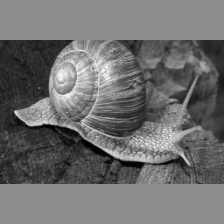

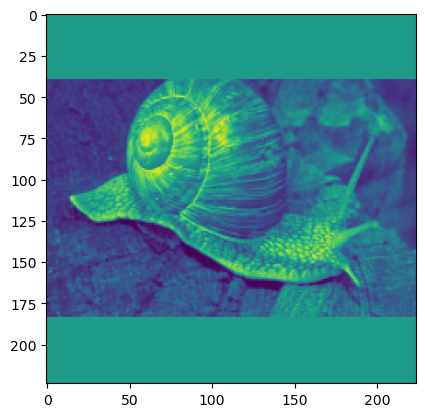

In [24]:
import matplotlib.pyplot as plt
img = padded_image[0, 0, ...]
print(img.shape)
# range of values
print(img.min(), img.max())
# convert to 0-1
img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img)
torchvision.transforms.functional.to_pil_image(img)


In [25]:
len(resnet50.layers)

4

In [26]:
# 3. layer has index 2
resnet50.layers[2][0].downsample[0].register_forward_hook(lambda self, input, output: print(output.shape))

In [27]:
with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(padded_image), dim=1)
    results = utils.pick_n_best(predictions=output, n=3)

torch.Size([128, 1024, 14, 14])
torch.Size([128, 1024, 14, 14])
sample 0: [('snail', '90.1%'), ('chambered nautilus, pearly nautilus, nautilus', '0.1%'), ('conch', '0.1%')]
sample 1: [('bucket, pail', '29.7%'), ('bathtub, bathing tub, bath, tub', '19.7%'), ('tub, vat', '9.3%')]
sample 2: [('baseball', '91.0%'), ('ballplayer, baseball player', '0.4%'), ('buckle', '0.3%')]
sample 3: [('ruffed grouse, partridge, Bonasa umbellus', '79.2%'), ('partridge', '3.8%'), ('web site, website, internet site, site', '0.3%')]
sample 4: [('sea lion', '69.8%'), ('killer whale, killer, orca, grampus, sea wolf, Orcinus orca', '1.0%'), ('dugong, Dugong dugon', '0.9%')]
sample 5: [('banjo', '80.5%'), ('seashore, coast, seacoast, sea-coast', '0.2%'), ('drum, membranophone, tympan', '0.2%')]
sample 6: [('electric fan, blower', '82.1%'), ('paddlewheel, paddle wheel', '2.4%'), ('pinwheel', '0.4%')]
sample 7: [('chickadee', '88.7%'), ('bulbul', '1.1%'), ('jay', '0.2%')]
sample 8: [('computer keyboard, keypad', '